In [7]:
%pylab inline

import sys
import os.path as op
from pathlib import Path
import shutil
# sys.path.insert(0, "/home/mjirik/projects/pyseg_base/")
sys.path.insert(0, op.abspath("../"))
import scipy
import time
import pandas as pd

from imcut import pycut
import sed3
import itertools
import data2tex as dtt
import io3d

latex_dir = "../../papers/cmbbeiv19/"

# sh 155,160, r10, dpoff 3, seeds 3
dataparams_sh =  list(range(44, 195, 10))
dataparams_sh =  list(range(44, 195, 1))
# dataparams_sh =  range(44, 195, 50)
dp_radius = [10]
dp_offset = [3, 5]
dp_seedsz = [3]

fname = "exp062-multiscale_delme.csv"
fnamenew = "msgc_experiment_ct.csv"


rnd_seed=1


Populating the interactive namespace from numpy and matplotlib


In [2]:
%pwd

'/auto/plzen1/home/mjirik/projects/imcut/examples'

## Methods setup

In [3]:
# block size bylo 10
segparams0 = {
    'method':'graphcut',
#     'method':'multiscale_graphcut',
    'use_boundary_penalties': True,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'block_size': 10,
    'tile_zoom_constant': 1
    }

segparams1 = {
    # 'method':'graphcut',
    'method':'multiscale_graphcut_hi2lo',
    'use_boundary_penalties': True,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'block_size': 10,
    'tile_zoom_constant': 1
    }

segparams2 = {
    # 'method':'graphcut',
    'method':'multiscale_graphcut_lo2hi',
    'use_boundary_penalties': True,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'block_size': 10,
    'tile_zoom_constant': 1
    }


labels = [
    "ssgc ",
    "msgc_hi2lo ",
    "msgc_lo2hi ",
]



In [35]:
data_seeds_path = Path(io3d.datasets.join_path("medical", "orig", "ircad1b_seeds", get_root=True)) 
d01_pth = data_seeds_path / "ircad1b01.pklz"

datap = io3d.read(d01_pth)
datap
str(d01_pth)
datap.keys()


dict_keys(['series_number', 'datadir', 'voxelsize_mm', 'version', 'crinfo', 'segmentation', 'apriori', 'slab', 'orig_shape', 'vessel_tree', 'saved_seeds', 'processing_information', 'experiment_caption', 'lisa_operator_identifier', 'data3d'])

In [32]:
# io3d.write(datap, data_seeds_path / "ircad1b01.hdf5")
# io3d.read(data_seeds_path / "ircad1b01.hdf5")

In [36]:
datap['saved_seeds']["left_kidney"]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ..., 
       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, 

In [49]:
pth_data3d = Path(io3d.datasets.join_path("medical", "orig", "3Dircadb1.{}", "PATIENT_DICOM", get_root=True)) 
pth_ground_true = Path(io3d.datasets.join_path("medical", "orig", "3Dircadb1.{}", "MASKS_DICOM", "{}"  get_root=True)) 
pth_seeds = Path(io3d.datasets.join_path("medical", "orig", "ircad1b_seeds", "ircad1b{:02d}.pklz", get_root=True)) 
print(pth_data3d)
print(pth_seeds)

e:\data\medical\orig\3Dircadb1.{}\PATIENT_DICOM
e:\data\medical\orig\ircad1b_seeds\ircad1b{:02d}.pklz


In [60]:
def prepare_data(i, ground_true_key, seeds_key):
    pth_data3d = Path(io3d.datasets.join_path("medical", "orig", "3Dircadb1.{}", "PATIENT_DICOM", get_root=True)) 
    pth_ground_true = Path(io3d.datasets.join_path("medical", "orig", "3Dircadb1.{}", "MASKS_DICOM", "{}", get_root=True)) 
    pth_seeds = Path(io3d.datasets.join_path("medical", "orig", "ircad1b_seeds", "ircad1b{:02d}.pklz", get_root=True)) 
    datap_data3d = io3d.read(str(pth_data3d).format(i))
    datap_seeds = io3d.read(str(pth_seeds).format(i))
    datap_ground_true = io3d.read(str(pth_ground_true).format(i, ground_true_key))
    seeds = datap_seeds["saved_seeds"][seeds_key]
    return datap_data3d["data3d"], datap_ground_true["data3d"], seeds
    
    

Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
C:\Users\miros\Miniconda3\envs\lisa36\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\miros\Miniconda3\envs\lisa36\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


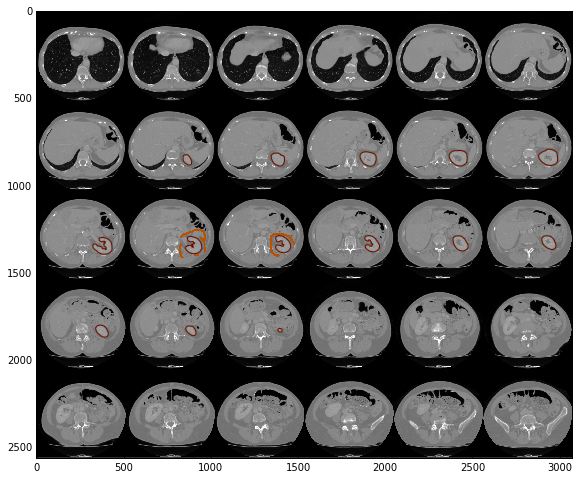

In [64]:
data3d, true_segmentation, seeds = prepare_data(1, "leftkidney", "left_kidney")
plt.figure(figsize=(10,8))
sed3.show_slices(data3d, seeds=seeds, contour=true_segmentation, shape=[5, 6])

In [37]:
"3Dircadb1.{}".format(5)

'3Dircadb1.5'

In [38]:
"asdfa{:02d}".format(5)

'asdfa05'

In [26]:

datap["processing_information"]["organ_segmentation"].keys()

dict_keys(['processing_time', 'time_start', 'oseg_input_params', 'organ_interactivity_counter', 'seeds'])

In [4]:
def make_data(sz=32, offset=0, radius=7, seedsz=3):
    #seedsz= int(sz/10)
    space=2
    seeds = np.zeros([sz, sz+1, sz+2], dtype=np.int8)
    xmin = radius + seedsz + offset + 2
    ymin = radius + seedsz + offset + 6
    seeds[offset + 12, xmin + 3:xmin + 7 + seedsz, ymin:ymin+2] = 1
    seeds[offset + 20, xmin + 7:xmin + 12 + seedsz, ymin+5:ymin+7] = 1
    img = np.ones([sz, sz+1, sz+2])
    img = img - seeds

    seeds[
        2:10 + seedsz, 
        2:9+ seedsz, 
        2:3+ seedsz] = 2
    img = scipy.ndimage.morphology.distance_transform_edt(img)
    segm = img < radius
    img = (100 * segm + 80 * np.random.random(img.shape)).astype(np.uint8)
    return img, segm, seeds


# Data screenshots

/storage/plzen1/home/mjirik/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/storage/plzen1/home/mjirik/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


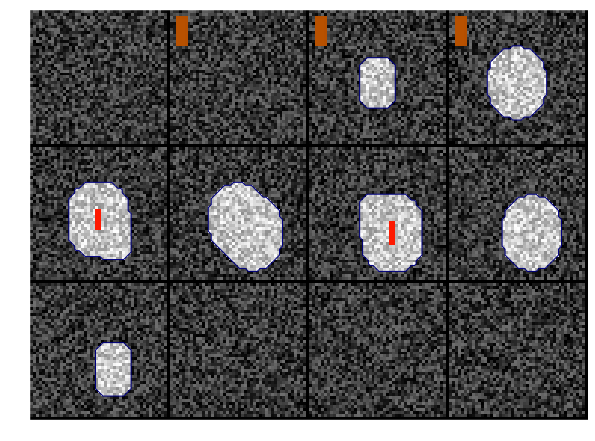

In [5]:

img, seg, seeds = make_data(45, 3, 10, 3)
plt.figure(figsize=(10,15))
import copy
imgview = copy.copy(img)
imgview[:,:,-1] = 0
imgview[:,-1,:] = 0
imgview[-1,:,:] = 0
sed3.show_slices(imgview, contour=seg, seeds=seeds, show=False, slice_step=3.9)
plt.axis("off")
plt.savefig("../graphics/exp062-imgsample_separated.png")

/storage/plzen1/home/mjirik/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/storage/plzen1/home/mjirik/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


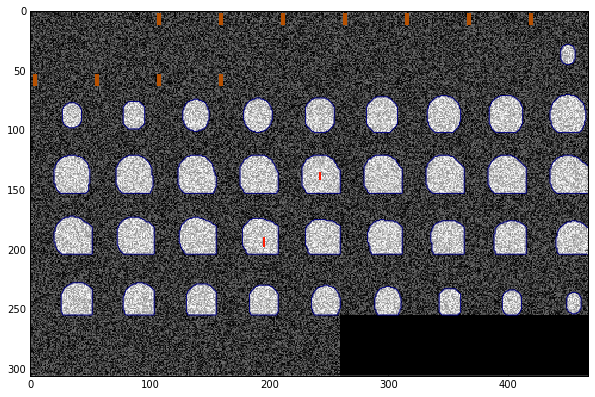

In [6]:

img, seg, seeds = make_data(50, 10, 15)
plt.figure(figsize=(10,15))
sed3.show_slices(img, contour=seg, seeds=seeds)

In [7]:
np.unique(seeds)

array([0, 1, 2], dtype=int8)

### LaTeX export functions

In [8]:
def to_latex_file(df, fn):
    with open(fn, "w") as f:
        f.write(df.to_latex())
        
def latex_float(f, precision=4):
    float_str = "{0:." + str(int(precision)) + "g}"
    float_str = float_str.format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
def float_to_latex_file(fl, fn, precision=4):
    string = latex_float(fl, precision=precision)
    with open(fn, "w") as f:
        f.write(string)

def num2latex(num, filename=None, precision=4):
    if type(num) is str:
        float_str = num
    else:
        float_str = "{0:." + str(int(precision)) + "g}"
        float_str = float_str.format(num)
        
    if float_str[:4] == r"\num":
        pass
    else:
        float_str = "\\num{" + float_str + "}" 
    if filename is not None:
        with open(filename, "w") as f:
            f.write(float_str)
    return float_str

def to_file(text, fn):
    with open(fn, "w") as f:
        f.write(text)

## Umělá data, opakovaný experiment

In [9]:
def process_gc_stats(stats1, prefix=None):
    if prefix is None:
        prefix = ""
    
        
    outstats = {}
    for key in stats1:
        outstats[prefix + key] = stats1[key]
        
    outstats[prefix + "nlinks number"] = np.sum(np.asarray(outstats[prefix + "nlinks shape"]), axis=0)[0]
    outstats[prefix + "tlinks number"] = np.sum(np.asarray(outstats[prefix + "tlinks shape"]), axis=0)[0]
    outstats.pop(prefix + "tlinks shape")
    outstats.pop(prefix + "nlinks shape")
    outstats[prefix + "edge number"] = outstats[prefix + "nlinks number"] + outstats[prefix + "tlinks number"]

    return outstats

    
def merge_stats(stats0, stats1, stats2, labels=None):
    if labels is None:
        labels = [""] * 3
    
   
    stats0 = process_gc_stats(stats0, labels[0])
    stats1 = process_gc_stats(stats1, labels[1])
    stats2 = process_gc_stats(stats2, labels[2])
    stats = {}
    stats.update(stats0)
    stats.update(stats1)
    stats.update(stats2)

    
    return stats

def run_gc_with_defined_setup(img, segparams, seeds):
    
    start = time.time()
    gc = pycut.ImageGraphCut(img, segparams=segparams)
    gc.set_seeds(seeds)
    gc.run()
    sg1 = gc.segmentation
    stats1 = gc.stats
    elapsed1 = (time.time() - start)
    err1 = np.sum(np.abs(seg - (1 - sg1)))
    stats1["time"] = elapsed1
    stats1["error"] = err1
    return stats1


def add_data_and_algoritm_info(stats, data_params, segparams, start):
    #     stats['msgc time'] = elapsed1
#     stats['normal time'] = elapsed2
    stats['data size'] = data_params[0]
    stats['data offset'] = data_params[1]
    stats['data radius'] = data_params[2]
    stats["block size"] = segparams["block_size"]
    stats["data seedsz"] = data_params[3]
#     stats["GC error"] = err2
#     stats["MSGC error"] = err1
    stats['machine hostname'] = machine_hostname
    stats['experiment iteration start time'] = start
    
    return stats

def add_data_seaborn(stats, data_params, segparams, start, i, label):
    stats = process_gc_stats(stats, "")
    stats = add_data_and_algoritm_info(stats, data_params, segparams, start)
    stats["method"] = label
    dfinew = pd.DataFrame(stats, index=[i*3 + 0])
    #dfnew = dfnew.append(dfinew, sort=True)
    
    return dfinew

In [10]:
#for par in it:
#    print par
i = 0

In [11]:
force_rewrite = False
force_rewrite = True

if op.exists(fname) and not force_rewrite:
    df = pd.read_csv(fname)#, index_col=0)
else:
    df = pd.DataFrame([])
    
if op.exists(fnamenew) and not force_rewrite:
    dfnew = pd.read_csv(fnamenew)#, index_col=0)
else:
    dfnew = pd.DataFrame([])


i = 0
np.random.seed(rnd_seed)

import platform
machine_hostname = platform.node()

it = itertools.product(dataparams_sh, dp_offset, dp_radius, dp_seedsz)
for data_params in it:

    start = time.time()
    img, seg, seeds = make_data(data_params[0], data_params[1], data_params[2], data_params[3])
    stats0 = run_gc_with_defined_setup(img, segparams0, seeds)
    stats1 = run_gc_with_defined_setup(img, segparams1, seeds)
    stats2 = run_gc_with_defined_setup(img, segparams2, seeds)

#     stats2 = gc.stats
#     elapsed2 = (time.time() - start)
#     err2 = np.sum(np.abs(seg - (1 - sg2)))
    
    
#     print(err1)
#     print("t1 / t2 =", elapsed1, "/" , elapsed2 ,' = ', elapsed1/elapsed2)
    
    stats = merge_stats(stats0, stats1, stats2, labels)
    
    stats = add_data_and_algoritm_info(stats, data_params, segparams0, start)
#     stats['msgc time'] = elapsed1
#     stats['normal time'] = elapsed2
#     stats['data size'] = data_params[0]
#     stats['data offset'] = data_params[1]
#     stats['data radius'] = data_params[2]
#     stats["block size"] = segparams1["block_size"]
#     stats["data seedsz"] = data_params[3]
# #     stats["GC error"] = err2
# #     stats["MSGC error"] = err1
#     stats['machine hostname'] = machine_hostname
#     stats['start time'] = start
    
    dfi = pd.DataFrame(stats, index=[i])
    
    # display(df)
    df = df.append(dfi, sort=True)
    df.to_csv(fname, index=False)
    
    
    
    
#     stats = process_gc_stats(stats0, "")
    dfinew = add_data_seaborn(stats0, data_params, segparams0, start, i, labels[0])
    dfnew = dfnew.append(dfinew, sort=True)
    dfinew = add_data_seaborn(stats1, data_params, segparams1, start, i, labels[1])
    dfnew = dfnew.append(dfinew, sort=True)
    dfinew = add_data_seaborn(stats2, data_params, segparams2, start, i, labels[2])
    dfnew = dfnew.append(dfinew, sort=True)
    
#     stats = process_gc_stats(stats1, "")
#     stats = add_data_and_algoritm_info(stats, data_params, segparams1, start)
#     dfinew = pd.DataFrame(stats, index=[i*3 + 1])
#     dfnew = dfnew.append(dfinew, sort=True)
    
#     stats = process_gc_stats(stats2, "")
#     stats = add_data_and_algoritm_info(stats, data_params, segparams2, start)
#     dfinew = pd.DataFrame(stats, index=[i*3 + 2])
#     dfnew = dfnew.append(dfinew, sort=True)
    dfnew.to_csv(fnamenew, index=False)
    
    
    
    
    
    i += 1
    

#     plt.figure(figsize=[10,15])
#     sed3.show_slices(img, contour=sg1, seeds=seeds, slice_step=10)
#     plt.figure(figsize=[10,15])
#     sed3.show_slices(img, contour=sg2, seeds=seeds, slice_step=10)

/storage/plzen1/home/mjirik/miniconda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [12]:
# dfnew.to_csv(fnamenew, index=False)
to_file(str(i), op.join(latex_dir, "msgc_dataset_size.tex"))

In [13]:
len(list(itertools.product(dataparams_sh, dp_offset, dp_radius, dp_seedsz)))

302

In [14]:
stats

{'ssgc _create_nlinks time': 3.8474199771881104,
 'ssgc gc time': 35.363853216171265,
 'ssgc time': 42.24955487251282,
 'ssgc error': 0,
 'ssgc nlinks number': 22129966,
 'ssgc tlinks number': 7414680,
 'ssgc edge number': 29544646,
 'msgc_hi2lo t1': 5.4836273193359375e-05,
 'msgc_hi2lo _create_nlinks time': 2.4560203552246094,
 'msgc_hi2lo gc time': 1.33320951461792,
 'msgc_hi2lo t2': 0.27971959114074707,
 'msgc_hi2lo t3': 0.282670259475708,
 'msgc_hi2lo t4': 1.7206535339355469,
 'msgc_hi2lo t5': 4.224681854248047,
 'msgc_hi2lo t6': 15.449214220046997,
 'msgc_hi2lo t7': 16.3068528175354,
 'msgc_hi2lo t8': 26.637968063354492,
 'msgc_hi2lo t9': 26.657761096954346,
 'msgc_hi2lo time': 28.10735011100769,
 'msgc_hi2lo error': 0,
 'msgc_hi2lo nlinks number': 658531,
 'msgc_hi2lo tlinks number': 219789,
 'msgc_hi2lo edge number': 878320,
 'msgc_lo2hi t1': 0.012177467346191406,
 'msgc_lo2hi _create_nlinks time': 0.003682374954223633,
 'msgc_lo2hi gc time': 0.9981119632720947,
 'msgc_lo2hi t2'

# Data processing graphs, statistics

In [15]:
df = pd.read_csv(fname)
# df.rename(columns={"msgc time": "MSGC time"})
dfs = df[(df["data seedsz"]==3) & (df["data offset"] == 3) & (df["data radius"] == 10)]
dfs_plus = dfs[dfs['data size'] > 160]

## Old graphs

In [16]:

# df["GC total time"] = df["normal time"]
# df["MSGC total time"] = df["msgc time"]
# df["GC time"] = df["normal gc time"]
# df["MSGC time"] = df["gc time"]
# df["MSGC links number"] = df["nlinks number"] + df["tlinks number"]
# df["GC links number"] = df["normal nlinks number"] + df["normal tlinks number"]
# df["time rate"] = df["gc time"] / df["normal gc time"]
# df["MSGC time rate"] = df["gc time"] / df["data size"]
# df["GC time rate"] = df["normal gc time"] / df["data size"]

def func(x, a, c, d):
    return a*np.exp(-c*x)+d

#from scipy.optimize import curve_fit
#popt, pcov = curve_fit(func, df["data size"], df["MSGC time"])
#print popt, pcov

#def msgcp(x):
#    a, c, d = popt
#    return a*np.exp(-c*x)+d
msgcp = np.poly1d(np.polyfit(df["data size"], df[labels[0] + "time"], 2))
df[labels[0] + "time trend"] = msgcp(df["data size"])
msgctp = np.poly1d(np.polyfit(df["data size"], df[labels[1] + "time"], 2))
df[labels[1] + "time trend"] = msgctp(df["data size"])


plt.figure()
df[[labels[0] + 'time', labels[1] + 'time', labels[2] + "time", 'data size']].sort_values("data size").plot(x='data size')
plt.figure(figsize=(10,15))
df[[labels[0] + 'time', labels[1] + 'time', labels[2] + "time",
    labels[0] + 'gc time', labels[1] + 'gc time', labels[2] + "gc time", 'data size',
   ]].sort_values("data size").plot(x='data size', style=["-o", "-^", "-s", ":", ":", ":"], color=["r", "g", "b", "r", "g", "b"])
plt.savefig("../graphics/exp062-msgc_time_size_comparison.pdf")


plt.figure()
#df[['normal nlinks number', "nlinks number", 'data size']].sort("data size").plot(x='data size')
df[[labels[0] + 'edge number', labels[1] + 'edge number', labels[2] + 'edge number', 'data size']].sort_values("data size").plot(
    x='data size')


# plt.figure()
# df[[labels[0] + 'time', labels[1] + "time", labels[1] + "time trend", 'data size']].sort_values("data size").plot(
#     x='data size', style=["-", "x", "-"])
# plt.savefig("../graphics/exp062-multiscale-time-data_size.pdf")
# plt.figure()
# df[['GC total time', "MSGC total time", "MSGC total time trend", 'data size']].sort_values("data size").plot(
#     x='data size', style=["-", "x", "-"])
# plt.savefig("../graphics/exp062-multiscale-total_time-data_size.pdf")

plt.figure()
df[[labels[0] + "time", labels[1] + "time", labels[2] + "time",]].boxplot(showfliers=False)
plt.savefig("../graphics/exp062-multiscale-gc_time.pdf")
plt.figure()
df[[labels[0] + 'time', labels[0] + 'gc time', labels[1] + "time",
    labels[1] + 'gc time', labels[2] + 'time', labels[2] + "gc time",
   
   ]].boxplot(showfliers=False, rot=90)
plt.savefig("../graphics/exp062-multiscale-gc_time-total_time.pdf")
# plt.figure()
# df[["GC total time", "MSGC total time"]].boxplot(showfliers=False)
# plt.savefig("../graphics/exp062-multiscale-total_time.pdf")

# plt.figure()
# df[['MSGC time', "GC links number", 'GC time']].sort_values("GC links number").plot(x='GC links number')



dfs = df[(df["data seedsz"]==3) & (df["data offset"] == 3) & (df["data radius"] == 10)]
# plt.figure()
# dfs[["GC total time", "MSGC total time", 'GC time', 'MSGC time', 'data size']].sort_values("data size").plot(x='data size', style=["-", "-", "--","--"])
# plt.savefig("../graphics/exp062-multiscale-all.pdf")

plt.figure()
dfs[[labels[0] + "edge number", labels[1] + "edge number", 'data size']].sort_values("data size").plot(x='data size', style=["-", "-", "--","--"])
plt.savefig("../graphics/exp062-multiscale-links_number.pdf")

df_mn = df[[labels[0] + "time", labels[1] + "time", labels[2] + "time", labels[0] + "gc time", labels[1] + "gc time", labels[2] + "gc time"]].describe()
display(df_mn)
def to_latex_file(df, fn):
    with open(fn, "w") as f:
        f.write(df.to_latex())
to_latex_file(df_mn, op.abspath("../includes/exp062-all.tex"))